# Methods development for MIMO SPS

add top level model to sys path, allows to refer other modules without performing local import

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


## Optimising Inverse of a matrix, using python numba

In [ ]:
import numpy as np
import control as ctrl

# Define the coefficients of the transfer functions
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0, 0.22]   # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
D = [0.31, 0.23]  # D(z^-1)

# Define transfer functions using the control library
A_tf = ctrl.TransferFunction(A, [1, 0])
B_tf = ctrl.TransferFunction(B, [1, 0])
C_tf = ctrl.TransferFunction(C, [1, 0])
D_tf = ctrl.TransferFunction(D, [1, 0])

# Create a system matrix G (2x2 matrix of transfer functions)
G = np.array([[B_tf, C_tf],
              [D_tf, B_tf]])

# Inverse of G (inverse of a matrix of transfer functions) not correct
G_inv = G**-1
print(G)
print("Inverse of G:", G_inv)
# np.inv not implemented


[[TransferFunction(array([0.22]), array([1, 0]))
  TransferFunction(array([1.  , 0.15]), array([1, 0]))]
 [TransferFunction(array([0.31, 0.23]), array([1, 0]))
  TransferFunction(array([0.22]), array([1, 0]))]]
Inverse of G: [[TransferFunction(array([1., 0.]), array([0.22]))
  TransferFunction(array([1., 0.]), array([1.  , 0.15]))]
 [TransferFunction(array([1., 0.]), array([0.31, 0.23]))
  TransferFunction(array([1., 0.]), array([0.22]))]]


In [10]:
import numpy as np
import numba as nb
import time

@nb.jit(nopython=True)
def lu_decomposition(A):
    n = A.shape[0]
    L = np.eye(n)
    U = A.copy()

    for i in range(n):
        for j in range(i + 1, n):
            factor = U[j, i] / U[i, i]
            L[j, i] = factor
            U[j, i:] -= factor * U[i, i:]

    return L, U

@nb.jit(nopython=True)
def forward_substitution(L, b):
    n = L.shape[0]
    y = np.zeros_like(b)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

@nb.jit(nopython=True)
def backward_substitution(U, y):
    n = U.shape[0]
    x = np.zeros_like(y)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
    return x

@nb.jit(nopython=True)
def invert_matrix(A):
    n = A.shape[0]
    L, U = lu_decomposition(A)
    inv_A = np.zeros_like(A)

    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        y = forward_substitution(L, e)
        x = backward_substitution(U, y)
        inv_A[:, i] = x

    return inv_A

# Define matrix size
n = 4
A = np.random.rand(n, n)  # Example random matrix

# Benchmark the matrix inversion
start_time = time.time()
A_inv = invert_matrix(A)
end_time = time.time()

print("Inverse matrix:")
print(A_inv)
print(f"Matrix inversion took {end_time - start_time:.6f} seconds")

# Verify the inverse is correct
identity = np.dot(A, A_inv)
print("Verification (should be close to identity matrix):")
print(identity)
np.testing.assert_allclose(np.eye(4), identity, atol=1e-10)


Inverse matrix:
[[ 11.1234026  -19.36460624   3.52352897   5.82037544]
 [ -2.21834764   2.71602748   0.25526463  -0.04163953]
 [-14.36437338  27.37452331  -7.30477679  -7.08574907]
 [  6.7460182  -11.43807368   4.15932786   1.609828  ]]
Matrix inversion took 3.249480 seconds
Verification (should be close to identity matrix):
[[ 1.00000000e+00 -2.31134343e-15 -3.70162923e-16  1.94017654e-18]
 [-1.50962053e-16  1.00000000e+00 -1.98595380e-17  4.08563448e-16]
 [ 5.14119951e-16 -1.54608419e-15  1.00000000e+00  2.77892019e-16]
 [-1.00925753e-15 -5.01378678e-15  5.04281324e-16  1.00000000e+00]]


In [ ]:
from cupyx.profiler import benchmark

print(benchmark(invert_matrix, (A, )))
print(benchmark(np.linalg.inv, (A, )))


invert_matrix       :    CPU:    20.711 us   +/- 14.437 (min:     8.700 / max:   257.300) us     GPU-0:    53.006 us   +/- 37.730 (min:     0.544 / max:   689.952) us
inv                 :    CPU:   195.704 us   +/- 145.932 (min:    76.200 / max:  8134.700) us     GPU-0:   262.484 us   +/- 162.124 (min:     0.800 / max:  8361.984) us


## Optimising ADD: polymul or convolve

In [ ]:
import numpy as np
from numba import njit
from scipy.signal import lfilter
from cupyx.profiler import benchmark
from numpy.polynomial.polynomial import polydiv
from numpy.polynomial.polyutils import trimseq

_epsilon = 1e-10


@njit
def _simplify_array(arr: np.ndarray, epsilon: float = _epsilon) -> np.ndarray:
    if arr.size == 1:
        return arr
    arr[np.abs(arr) < epsilon] = 0
    arr = trimseq(arr)
    return arr

@njit
def _simplify(num, den, epsilon: float = _epsilon) -> Tuple[np.ndarray, np.ndarray]:
    return _simplify_array(num, epsilon),  _simplify_array(den, epsilon)

@njit
def _ensure_same_size(p1: np.ndarray, p2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    size1, size2 = p1.size, p2.size
    max_size = max(size1, size2)

    if size1 < max_size:
        p1 = np.concatenate((p1, np.zeros(max_size - size1, dtype=p1.dtype)))
    if size2 < max_size:
        p2 = np.concatenate((p2, np.zeros(max_size - size2, dtype=p2.dtype)))

    return p1, p2

@nb.jit(nopython=True,fastmath=True)
def _convolve(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    return _simplify_array(np.convolve(arr1, arr2))

@njit
def _add_tfs(num1: np.ndarray, den1: np.ndarray, num2: np.ndarray, den2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        num_self = _convolve(num1, den2) 
        num_other = _convolve(num2, den1)
        num_self, num_other = _ensure_same_size(num_self, num_other)
        num = num_self + num_other
        # new common denom
        den = _convolve(den1, den2)
        
        # Find the index of the first nonzero element
        gcd = den[np.argmax(den != 0)]
        num = num / gcd
        den = den / gcd
        return num, den

In [ ]:
from numpy.polynomial import polynomial as P
@njit(fastmath=True)
def njit_polymul(p1, p2):
    return P.polymul(p1,p2)

### Benchmarking P.polymul, P.polymul with njit function, _covolution

In [ ]:
# small arrays ours is better
c1 = np.random.rand(4, )
c2 = np.random.rand(5, )


print(benchmark(P.polymul, (c1, c2), n_repeat=10000))
print(benchmark(njit_polymul, (c1, c2), n_repeat=10000))
print(benchmark(_convolve,(c1, c2), n_repeat=10000))

polymul             :    CPU:    25.962 us   +/- 15.944 (min:    15.800 / max:   625.400) us     GPU-0:    51.054 us   +/- 88.765 (min:     2.176 / max:  1863.616) us
njit_polymul        :    CPU:     9.819 us   +/-  4.251 (min:     6.200 / max:   108.600) us     GPU-0:    31.354 us   +/- 77.686 (min:     2.240 / max:  1803.360) us
_convolve           :    CPU:     7.620 us   +/-  2.273 (min:     5.700 / max:    39.700) us     GPU-0:    29.572 us   +/- 72.752 (min:     2.240 / max:  1833.888) us


In [ ]:
# medium sized array they are performing similar
c1 = np.random.rand(20, )
c2 = np.random.rand(25, )
print(benchmark(P.polymul, (c1, c2), n_repeat=10000))
print(benchmark(njit_polymul, (c1, c2), n_repeat=10000))
print(benchmark(_convolve,(c1, c2), n_repeat=10000))

polymul             :    CPU:    34.859 us   +/- 16.999 (min:    16.900 / max:   324.200) us     GPU-0:    64.792 us   +/- 46.749 (min:     0.544 / max:  1818.560) us
njit_polymul        :    CPU:    30.858 us   +/-  9.711 (min:    21.300 / max:   141.700) us     GPU-0:    52.329 us   +/- 21.988 (min:     0.512 / max:   501.408) us
_convolve           :    CPU:    28.795 us   +/- 10.853 (min:    18.100 / max:   225.800) us     GPU-0:    49.469 us   +/- 22.907 (min:     0.480 / max:   659.040) us


In [ ]:
# really large arrays, polymul is more optimised
c1 = np.random.rand(100, )
c2 = np.random.rand(100, )
print(benchmark(P.polymul, (c1, c2), n_repeat=10000))
print(benchmark(njit_polymul, (c1, c2), n_repeat=10000))
print(benchmark(_convolve,(c1, c2), n_repeat=10000))

polymul             :    CPU:    40.572 us   +/- 27.783 (min:    23.000 / max:  1284.500) us     GPU-0:    74.625 us   +/- 116.618 (min:     2.208 / max:  1843.840) us
njit_polymul        :    CPU:   127.977 us   +/- 43.516 (min:    72.700 / max:   777.900) us     GPU-0:   159.084 us   +/- 146.501 (min:     2.208 / max:  2103.264) us
_convolve           :    CPU:   164.298 us   +/- 143.030 (min:    80.200 / max: 10683.100) us     GPU-0:   201.133 us   +/- 223.327 (min:     2.208 / max: 11220.992) us


### with  really really small numbers, we remove them for numerical stability

In [ ]:
p1 = np.array([1.0, 2, 1, 1e-10])  
p2 = np.array([1.0, 2, 1e-100])  
print(P.polymul(p1, p2))
print(_convolve(p1, p2))

print(benchmark(P.polymul, (p1, p2), n_repeat=10000))
print(benchmark(njit_polymul, (p1, p2), n_repeat=10000))
print(benchmark(_convolve,(p1, p2), n_repeat=10000))

[1.e+000 4.e+000 5.e+000 2.e+000 2.e-010 1.e-110]
[1.e+00 4.e+00 5.e+00 2.e+00 2.e-10]
polymul             :    CPU:    23.640 us   +/- 13.134 (min:    15.700 / max:   468.000) us     GPU-0:    47.279 us   +/- 95.862 (min:     2.240 / max:  2410.752) us
njit_polymul        :    CPU:     9.897 us   +/-  3.970 (min:     7.000 / max:    80.800) us     GPU-0:    28.722 us   +/- 48.947 (min:     2.240 / max:  1361.376) us
_convolve           :    CPU:     8.492 us   +/-  6.492 (min:     4.900 / max:   269.900) us     GPU-0:    27.398 us   +/- 55.512 (min:     2.272 / max:  1637.280) us


## Optimising Sub: polysub

In [ ]:
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _poly_sub
print(_poly_sub(p1, p2))
print(P.polysub(p1,p2))
print(benchmark(_poly_sub, (c1, c2)))
print(benchmark(P.polysub, (c1, c2)))

[0. 0. 1.]
_poly_sub           :    CPU:     7.853 us   +/-  6.982 (min:     4.300 / max:   234.900) us     GPU-0:    32.863 us   +/- 46.641 (min:     0.480 / max:  1910.784) us
polysub             :    CPU:    31.330 us   +/- 15.651 (min:    24.200 / max:  1260.900) us     GPU-0:    55.758 us   +/- 25.487 (min:     0.480 / max:  1412.096) us


## simplifying polynomial fractions

simplifying fractions using polydiv

In [ ]:
import numpy as np
import sympy as sp
from numpy.polynomial.polynomial import polydiv
from numpy.polynomial.polyutils import trimseq


@njit
def gcd_polynomials(p1: np.ndarray, p2: np.ndarray, tol: float = _epsilon):
    """Compute the GCD of two polynomials using the Euclidean algorithm with numerical stability."""
    p1, p2 = _simplify(p1, p2)
    while np.any(np.abs(p2) > tol):  # Ensure small values don't cause infinite loops
        _, remainder = polydiv(p1, p2)
        p1, p2 = p2, trimseq(remainder)  # Trim leading zeros using trimseq
    return trimseq(p1)  # Trim leading zeros

@njit
def reduce_fraction_numpy(num: np.ndarray, den: np.ndarray, tol: float = _epsilon):
    """Reduce a polynomial fraction by dividing by the GCD."""
    gcd = gcd_polynomials(num, den)  # Compute GCD
    if np.all(np.abs(gcd) < tol):  # If GCD is too small, return the original fraction
        return num, den
    # Perform polynomial division
    num_reduced, _ = polydiv(num, gcd)
    den_reduced, _ = polydiv(den, gcd)

    # ensure the first number is 1
    gcd = den_reduced[np.argmax(den != 0)]
    num_reduced = num_reduced / gcd
    den_reduced = den_reduced / gcd
    return _simplify(num_reduced, den_reduced)


def factorize_and_simplify(num: np.ndarray, den: np.ndarray):
    x = sp.Symbol('x')  # Define symbolic variable
    
    # Convert numpy arrays to sympy polynomials
    num_poly = sp.Poly(num.tolist(), x)
    den_poly = sp.Poly(den.tolist(), x)

    # Factorize the numerator and denominator
    num_factored = sp.factor(num_poly)
    den_factored = sp.factor(den_poly)

    # Simplify by canceling common factors
    simplified_expr = sp.simplify(num_factored / den_factored)

    # Get simplified numerator and denominator
    simplified_num, simplified_den = sp.fraction(simplified_expr)

    # Convert back to numpy arrays
    num_coeffs = np.array(sp.Poly(simplified_num, x).all_coeffs(), dtype=float)
    den_coeffs = np.array(sp.Poly(simplified_den, x).all_coeffs(), dtype=float)

    return num_coeffs, den_coeffs, simplified_expr




In [ ]:
# Example: Reduce (x^3 + 3x^2 + 3x + 1) / (x^2 + 2x + 1)
num = np.array([1.0, 3.0, 3.0, 1.0])  
den = np.array([1.0, 8, 1e-30, 1e-8])   

simplified_num, simplified_den = reduce_fraction_numpy(num, den)

print("Simplified Numerator:", simplified_num)
print("Simplified Denominator:", simplified_den)

simplified_num, simplified_den, exp = factorize_and_simplify(num, den)

print("Simplified Numerator:", simplified_num)
print("Simplified Denominator:", simplified_den)
print("Simplified exp:", exp)


print(benchmark(reduce_fraction_numpy, (num, den), n_repeat=10000))


Simplified Numerator: [0.33007813 0.359375   0.125     ]
Simplified Denominator: [ 1.00000000e+00 -1.56249999e-10  1.25000000e-09]
Simplified Numerator: [1. 3. 3. 1.]
Simplified Denominator: [1.e+00 8.e+00 0.e+00 1.e-08]
Simplified exp: (1.0*x**3 + 3.0*x**2 + 3.0*x + 1.0)/(1.0*x**3 + 8.0*x**2 + 1.0e-8)
reduce_fraction_numpy:    CPU:    23.063 us   +/-  7.036 (min:    14.800 / max:   115.600) us     GPU-0:    45.030 us   +/- 55.069 (min:     2.336 / max:  1175.456) us


Also need to factorise, implementing ctrl.minreal using numba

In [ ]:
import numpy as np

@njit
def poly_divide(a, b):
    """Divide polynomial a(x) by b(x), return quotient and remainder."""
    quotient, remainder = polydiv(a, b)
    quotient, remainder = _simplify(quotient, remainder)
    return quotient, remainder

@njit
def poly_sub(p, q):
    """Subtract p-q"""
    p,q = _ensure_same_size(p, q)
    return p-q

@njit
def eGCD(f, g, tolerance=_epsilon):
    """Compute the GCD of two polynomials and the coefficients u(x) and v(x)."""

    # Initialize u(x) and v(x)
    u0, v0 = np.array([1.0]), np.array([0.0])
    u1, v1 = np.array([0.0]), np.array([1.0])

    while np.any(np.abs(g) > tolerance):
        q, r = poly_divide(f, g)

        f, g = g, r  # Update for next iteration
        if np.all(np.abs(g) < tolerance):
            g = np.zeros_like(g)

        # Update u and v
        u2 = poly_sub(u0, np.convolve(q, u1))
        v2 = poly_sub(v0, np.convolve(q, v1))

        u2, _ = _ensure_same_size(u2, u0)
        v2, _ = _ensure_same_size(v2, v0)

        # Ensure correct sizes
        u0, u1 = u1, u2
        v0, v1= v1, v2

    gcd = f  # The remaining f is the GCD
    return gcd, u0, v0

@njit
def reduce_fraction_numpy(num: np.ndarray, den: np.ndarray, tol: float = _epsilon):
    """Reduce a polynomial fraction by dividing by the GCD."""
    gcd, _, _ = eGCD(num, den)  # Compute GCD
    if np.all(np.abs(gcd) < tol):  # If GCD is too small, return the original fraction
        return num, den
    # Perform polynomial division
    num_reduced, _ = polydiv(num, gcd)
    den_reduced, _ = polydiv(den, gcd)

    # ensure the first number is 1
    gcd = den_reduced[np.argmax(den != 0)]
    num_reduced = num_reduced / gcd
    den_reduced = den_reduced / gcd
    return _simplify(num_reduced, den_reduced)


In [ ]:
import control as ctrl
# Example usage:
num = np.array([1.0, -3.0, 3.0, 1.0])  # f(x) = x^3 + 3x^2 + 3x + 1
den = np.array([1.0, 8, 10, 1e-8])         # g(x) = x^2 + 8x + 1e-30
sys = ctrl.tf(num, den)
print(reduce_fraction_numpy(num, den))

print(benchmark(reduce_fraction_numpy, (num, den), n_repeat=100000))
print(benchmark(ctrl.minreal, (sys, 1e-10, False), n_repeat=100000))

(array([ 1., -3.,  3.,  1.]), array([1.e+00, 8.e+00, 1.e+01, 1.e-08]))
reduce_fraction_numpy:    CPU:    45.610 us   +/- 17.232 (min:    22.500 / max:  1298.200) us     GPU-0:    69.800 us   +/- 68.484 (min:     0.448 / max:  6967.200) us
minimal_realization :    CPU:   432.374 us   +/- 209.217 (min:   237.000 / max: 21259.400) us     GPU-0:   478.906 us   +/- 293.799 (min:     2.208 / max: 21988.001) us


## Implementing lfilter using numba and benchmarking

Mean Absolute Error between SciPy and Numba: 4.210540e-17


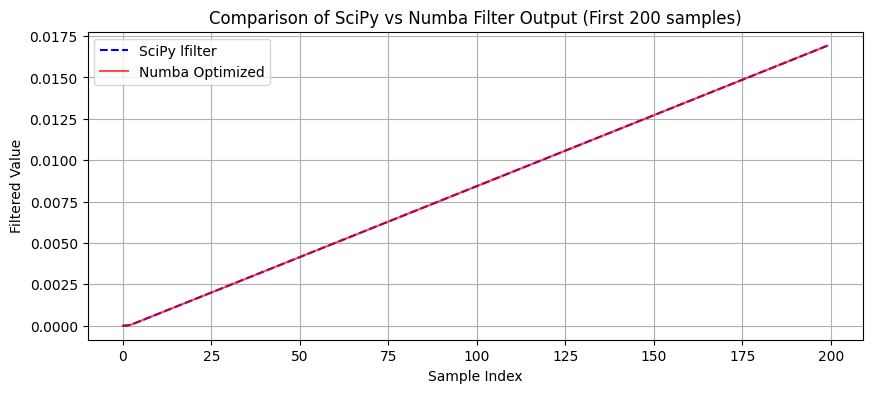

SciPy lfilter time: 0.000000 seconds
Numba-optimized filter time: 0.350239 seconds
Speedup factor: 0.00x


In [ ]:
import numpy as np
import numba
import time
import matplotlib.pyplot as plt
from scipy.signal import lfilter

@numba.jit(nopython=True, fastmath=True)
def iir_filter_numba(x, num, den):
    """
    Optimized IIR filter using convolution for FIR part and Numba JIT for recursion.
    """
    N = len(x)
    y = np.convolve(x, num, mode='full')[:N]  # Apply FIR part

    den = den / den[0]  # Normalize denominator coefficients

    for n in range(1, N):  
        for k in range(1, len(den)):
            if n - k >= 0:
                y[n] -= den[k] * y[n - k]

    return y

# Define filter coefficients
num = np.array([0.1, 0.2, 0.3])  # Numerator coefficients
den = np.array([1.0, -0.4, 0.1])  # Denominator coefficients

# Generate test input signal
x = np.sin(np.linspace(0, 100, 10**6))  # Large signal (1 million samples)

# Apply filters
y_scipy = lfilter(num, den, x)
y_numba = iir_filter_numba(x, num, den)

# --- VALIDATION ---
# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_scipy - y_numba))
print(f"Mean Absolute Error between SciPy and Numba: {mae:.6e}")

# Plot the first 200 samples for visual comparison
plt.figure(figsize=(10, 4))
plt.plot(y_scipy[:200], label="SciPy lfilter", linestyle='dashed', color='b')
plt.plot(y_numba[:200], label="Numba Optimized", linestyle='solid', color='r', alpha=0.7)
plt.legend()
plt.title("Comparison of SciPy vs Numba Filter Output (First 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Filtered Value")
plt.grid(True)
plt.show()

# --- BENCHMARKING ---
# Time SciPy implementation
start_scipy = time.time()
y_scipy = lfilter(num, den, x)
end_scipy = time.time()

# Time Numba implementation
start_numba = time.time()
y_numba = iir_filter_numba(x, num, den)  # Second run actual timing
end_numba = time.time()

# Print timing results
print(f"SciPy lfilter time: {end_scipy - start_scipy:.6f} seconds")
print(f"Numba-optimized filter time: {end_numba - start_numba:.6f} seconds")
print(f"Speedup factor: {(end_scipy - start_scipy) / (end_numba - start_numba):.2f}x")


optimising numba implementation

Mean Absolute Error between SciPy and Numba: 4.434926e-17


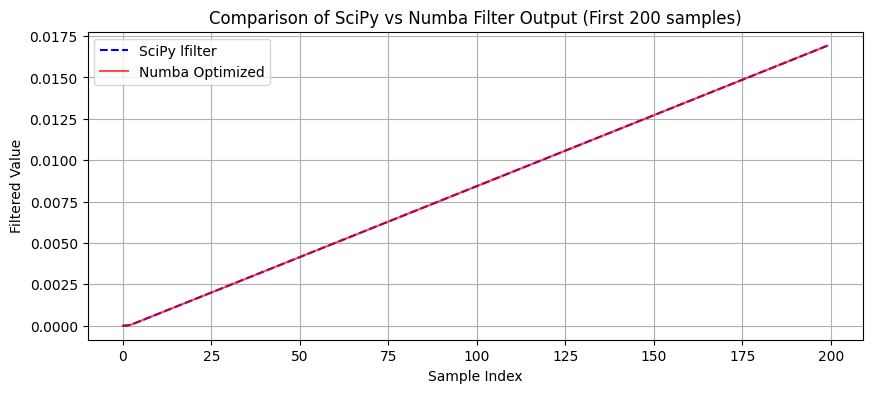

lfilter             :    CPU:  8546.250 us   +/- 2289.837 (min:  6414.200 / max: 13666.300) us     GPU-0:  9214.368 us   +/- 2614.430 (min:  6535.616 / max: 14838.112) us
iir_filter_numba    :    CPU:  8638.210 us   +/- 1426.707 (min:  6933.400 / max: 11416.400) us     GPU-0:  9443.082 us   +/- 1535.223 (min:  6639.840 / max: 12329.088) us


In [ ]:


@numba.jit(nopython=True, fastmath=True, parallel=False)
def iir_filter_numba(num, den, x):
    """
    Implements a digital filter using direct form difference equation.
    
    Parameters:
        num (numpy array): Numerator coefficients
        den (numpy array): Denominator coefficients (assumes den[0] != 0)
        x (numpy array): Input time series

    Returns:
        numpy array: Filtered output
    """
    N = len(x)
    M = len(num)
    K = len(den)
    
    y = np.zeros(N)  # Initialize output array
    
    # Normalize by den[0] (typically should be 1, but just in case)
    num = num / den[0]
    den = den / den[0]

    # Apply filter using the difference equation
    for n in range(N):
        # Apply numerator (FIR part)
        for m in range(M):
            if n - m >= 0:
                y[n] += num[m] * x[n - m]
        
        # Apply denominator (IIR part)
        for k in range(1, K):  # Start from 1 because den[0] is already normalized
            if n - k >= 0:
                y[n] -= den[k] * y[n - k]

    return y


@numba.jit(nopython=True, fastmath=True, parallel=True)
def iir_filter_numba2(num, den, x):
    """
    Optimized IIR filter using convolution for FIR part and Numba JIT for recursion.
    """
    N = len(x)
    y = np.convolve(x, num, mode='full')[:N]  # Apply FIR part

    den = den / den[0]  # Normalize denominator coefficients

    for n in range(1, N):  
        for k in range(1, len(den)):
            if n - k >= 0:
                y[n] -= den[k] * y[n - k]

    return y

# Define filter coefficients
num = np.array([0.1, 0.2, 0.3])  # Numerator coefficients
den = np.array([1.0, -0.4, 0.1])  # Denominator coefficients

# Generate test input signal
x = np.sin(np.linspace(0, 100, 10**6))  # Large signal (1 million samples)

# Apply filters
y_scipy = lfilter(num, den, x)
y_numba = iir_filter_numba(num, den, x)

# --- VALIDATION ---
# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_scipy - y_numba))
print(f"Mean Absolute Error between SciPy and Numba: {mae:.6e}")

# Plot the first 200 samples for visual comparison
plt.figure(figsize=(10, 4))
plt.plot(y_scipy[:200], label="SciPy lfilter", linestyle='dashed', color='b')
plt.plot(y_numba[:200], label="Numba Optimized", linestyle='solid', color='r', alpha=0.7)
plt.legend()
plt.title("Comparison of SciPy vs Numba Filter Output (First 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Filtered Value")
plt.grid(True)
plt.show()


# Benchmark SciPy
print(benchmark(lfilter, (num, den, x), n_repeat=100))
print(benchmark(iir_filter_numba, (num, den, x), n_repeat=100))

### benchmark against lfilter
clearly lfilter is superior so use that


In [ ]:
# Benchmark SciPy
print(benchmark(lfilter, (num, den, x), n_repeat=1000, n_warmup=10))
print(benchmark(iir_filter_numba, (num, den, x), n_repeat=1000, n_warmup=10))
print(benchmark(iir_filter_numba2, (num, den, x), n_repeat=10, n_warmup=10))

lfilter             :    CPU: 10054.169 us   +/- 1998.901 (min:  6843.300 / max: 16946.000) us     GPU-0: 10634.029 us   +/- 2108.193 (min:  6161.728 / max: 17798.559) us
iir_filter_numba    :    CPU: 10004.841 us   +/- 2192.192 (min:  6192.200 / max: 24186.600) us     GPU-0: 10573.682 us   +/- 2246.100 (min:  5914.752 / max: 25177.631) us
iir_filter_numba2   :    CPU: 344328.130 us   +/- 37970.271 (min: 291745.700 / max: 413547.000) us     GPU-0: 345082.706 us   +/- 37977.744 (min: 292383.667 / max: 414199.585) us


## Mtrix operations with d_tfs

In [4]:
from indirect_identification.d_tfs import d_tfs
import numpy as np
import numba as nb

# Define the coefficients of the transfer functions
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0, 0.22]   # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
D = [0.31, 0.23]  # D(z^-1)

# Define transfer functions using the control library
A_tf = d_tfs((A, [1, 0]))
B_tf = d_tfs((B, [1, 0]))
C_tf = d_tfs((C, [1, 0]))
D_tf = d_tfs((D, [1, 0]))

# Create a system matrix G (2x2 matrix of transfer functions)
G = np.array([[B_tf, C_tf],
              [D_tf, B_tf]])
print(G)

[[Transfer Function: num=[0.   0.22], den=[1. 0.]
  Transfer Function: num=[1.   0.15], den=[1. 0.]]
 [Transfer Function: num=[0.31 0.23], den=[1. 0.]
  Transfer Function: num=[0.   0.22], den=[1. 0.]]]


### stability checks
faster with just njit, fastmath leads to some unexpected delays. 

In [12]:
from cupyx.profiler import benchmark
def is_stable(den, epsilon=0.001) -> bool:   
    """
    Check if the discrete transfer function is stable.
    Returns:
    bool: True if stable (all poles inside the unit circle), False otherwise.
    """
    poles = np.roots(den)  # Compute poles (roots of denominator)
    return np.all(np.abs(poles) < 1-epsilon)  # Check if all poles are inside the unit circle

@nb.jit(nopython=True, fastmath=True)
def is_stable_2(den: np.ndarray, epsilon: float = 0.001) -> bool:   
    """
    Check if the discrete transfer function is stable.
    Returns:
    bool: True if stable (all poles inside the unit circle), False otherwise.
    """
    poles = np.roots(den)  # Compute poles (roots of denominator)
    return np.all(np.abs(poles) < 1-epsilon)  # Check if all poles are inside the unit circle

@nb.njit
def is_stable_3(den: np.ndarray, epsilon: float = 0.001) -> bool:   
    """
    Check if the discrete transfer function is stable.
    Returns:
    bool: True if stable (all poles inside the unit circle), False otherwise.
    """
    poles = np.roots(den)  # Compute poles (roots of denominator)
    return np.all(np.abs(poles) < 1-epsilon)  # Check if all poles are inside the unit circle

print(benchmark(is_stable, (A_tf.den, 0.001), n_repeat=100000))
print(benchmark(is_stable_2, (A_tf.den, 0.001), n_repeat=100000))
print(benchmark(is_stable_3, (A_tf.den, 0.001), n_repeat=100000))

is_stable           :    CPU:    47.677 us   +/- 16.207 (min:    27.400 / max:  1415.800) us     GPU-0:    93.802 us   +/- 351.228 (min:     2.048 / max: 12115.040) us
is_stable_2         :    CPU:     3.055 us   +/-  3.344 (min:     1.600 / max:   395.700) us     GPU-0:    24.524 us   +/- 131.148 (min:     2.016 / max:  7612.256) us
is_stable_3         :    CPU:     3.024 us   +/-  2.066 (min:     1.800 / max:    69.900) us     GPU-0:    24.296 us   +/- 114.028 (min:     2.016 / max:  7485.568) us


### matrix operations, add, matrix mult, elementiwise mults

In [13]:
# elementwise mult
print(G*np.eye(G.shape[0]), (G*np.eye(G.shape[0])).shape)
# matrix mults
    # mult with 2x2
print(G @ np.eye(2), (G @ np.eye(2)).shape)
    # mult with 2x1, should result in 2x1
print(G @ np.array([1, 1]), (G @ np.array([1,1])).shape)
    # should be same as row sums 
print(B_tf + C_tf, D_tf + B_tf)

[[Transfer Function: num=[0.   0.22], den=[1. 0.]
  Transfer Function: num=[0. 0.], den=[1. 0.]]
 [Transfer Function: num=[0. 0.], den=[1. 0.]
  Transfer Function: num=[0.   0.22], den=[1. 0.]]] (2, 2)
[[Transfer Function: num=[0.   0.22], den=[1.]
  Transfer Function: num=[1.   0.15], den=[1.]]
 [Transfer Function: num=[0.31 0.23], den=[1.]
  Transfer Function: num=[0.   0.22], den=[1.]]] (2, 2)
[Transfer Function: num=[1.   0.37], den=[1.]
 Transfer Function: num=[0.31 0.45], den=[1.]] (2,)
Transfer Function: num=[1.   0.37], den=[1.] Transfer Function: num=[0.31 0.45], den=[1.]


In [ ]:
u_t = np.random.random((2, 10))
print("u_t: ", u_t)

# similar performance for both ways
def apply_tf_matrix(G, U):
    m, n = G.shape
    k = U.shape[1]
    Y = np.zeros((m, k))

    for i in range(m):
        for j in range(n):
            Y[i, :] += G[i, j] * U[j, :] 
    return Y

def apply_tf_matrix_2(G, U):
    m, n = G.shape
    k = U.shape[1]
    Y = np.zeros((m, k))
    # Vectorized summation instead of explicit loop accumulation
    for i in range(m):
        Y[i, :] = sum([G[i, j]*(U[j, :]) for j in range(n)])
    return Y
Y=apply_tf_matrix(G,u_t)
print(Y)
print(np.allclose((G[0,0]*u_t[0,:] + G[0,1]*u_t[1,:]), Y[0]))
print(benchmark(apply_tf_matrix, (G, u_t), n_repeat=50000))
print(benchmark(apply_tf_matrix_2, (G, u_t), n_repeat=50000))

u_t:  [[0.06938647 0.36718085 0.73143485 0.21070124 0.66267288 0.72865944
  0.12371095 0.70269296 0.35754918 0.6404709 ]
 [0.07433697 0.64361441 0.3559575  0.80766744 0.68092529 0.798897
  0.29548275 0.64736444 0.83299342 0.04451566]]
[[0.07434381 0.67007091 0.53337284 1.0220383  0.84848666 1.04693089
  0.57566522 0.71895807 1.08477006 0.24818985]
 [0.02151948 0.1462222  0.45290679 0.31197051 0.43171706 0.52825356
  0.38178828 0.31138207 0.41503177 0.46411705]]
True
apply_tf_matrix     :    CPU:   163.204 us   +/- 193.661 (min:    87.800 / max: 35211.900) us     GPU-0:   250.977 us   +/- 652.309 (min:     2.208 / max: 43997.410) us
apply_tf_matrix_2   :    CPU:   157.846 us   +/- 83.909 (min:   101.200 / max:  6053.500) us     GPU-0:   248.812 us   +/- 637.974 (min:     2.208 / max: 13008.960) us


In [ ]:
u_t = np.array([np.array(np.random.random((10, )), dtype=object), np.array(np.random.random((10, )), dtype=object)])

array([[Transfer Function: num=[5.47038286e-01 1.76332720e-01 2.17572473e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[4.19252098e-01 2.79031386e-01 2.87931707e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[6.45982321e-01 2.72300150e-01 3.10888090e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[2.49215599e-01 7.95283464e-02 9.84429150e-06], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[4.99922045e-01 1.92322754e-01 2.25090677e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[2.91838306e-01 1.78211707e-01 1.86935136e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[9.68972936e-01 1.62040468e-01 2.58806167e-05], den=[1.00000000e+00 2.52672527e-04 1.41878723e-08],
        Transfer Function: num=[4.97031570e-01 2.87281961e-01 3.04700236e-05], den=

The basics operations work as intended as the np uses operations defined in d_tfs, however we also require matrix inverse but np matrix inverse only works with numbers and not with a class object. 

## MIMO TF matrix inverse

### Extending matrix inverse to d_tfs class

earlier in [Optimising matrix inverse](#optimising-inverse-of-a-matrix-using-python-numba), we optimised the matrix inverse using LU decomposition and numba. Now we extend the implementation to take in d_tfs objects as well. 

### LU Decomp method

In [6]:
import numpy as np
import numba as nb
import time
from cupyx.profiler import benchmark

@nb.jit(nopython=True, fastmath=True)
def lu_decomposition(A):
    n = A.shape[0]
    L = np.eye(n)
    U = A.copy()

    for i in range(n):
        for j in range(i + 1, n):
            # print("lu_decomposition: U[j,i], U[i, i]: ", U[j,i], U[i,i])
            factor = U[j, i] / U[i, i]
            L[j, i] = factor
            # print(U[i, i:])
            U[j, i:] -= factor * U[i, i:]

    # print("lu_decomposition: ", L, U)
    return L, U

@nb.jit(nopython=True, fastmath=True)
def forward_substitution(L, b):
    n = L.shape[0]
    y = np.zeros_like(b)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

@nb.jit(nopython=True, fastmath=True)
def backward_substitution(U, y):
    n = U.shape[0]
    x = np.zeros_like(y)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
    return x

@nb.jit(nopython=True, fastmath=True)
def invert_matrix(A):
    n = A.shape[0]
    L, U = lu_decomposition(A)
    inv_A = np.zeros_like(A)

    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        y = forward_substitution(L, e)
        x = backward_substitution(U, y)
        inv_A[:, i] = x

    return inv_A

# Define matrix size
n = 2
A = np.random.rand(n, n)  # Example random matrix

# Benchmark the matrix inversion
start_time = time.time()
A_inv = invert_matrix(A)
end_time = time.time()

print("Inverse matrix:")
print(A_inv)
print(f"Matrix inversion took {end_time - start_time:.6f} seconds")

# Verify the inverse is correct
identity = np.dot(A, A_inv)
print("Verification (should be close to identity matrix):")
print(identity)
np.testing.assert_allclose(np.eye(2), identity, atol=1e-10)

print(benchmark(invert_matrix, (A, ), n_repeat=10000))
print(benchmark(np.linalg.inv, (A, ), n_repeat=10000))



Inverse matrix:
[[-1.94789361  2.20677122]
 [ 2.72357805 -1.59433241]]
Matrix inversion took 2.688605 seconds
Verification (should be close to identity matrix):
[[1.00000000e+00 7.21438629e-17]
 [2.25180552e-16 1.00000000e+00]]
invert_matrix       :    CPU:     8.453 us   +/-  7.558 (min:     5.000 / max:   134.100) us     GPU-0:    28.293 us   +/- 27.319 (min:     2.368 / max:  1163.072) us
inv                 :    CPU:    98.228 us   +/- 33.048 (min:    53.900 / max:  1171.600) us     GPU-0:   145.855 us   +/- 42.354 (min:    79.264 / max:  1380.288) us


### LU method inverse for d_fts

In [ ]:
import numpy as np
import numba as nb
import time

# @nb.jit(nopython=True)
def lu_decomposition(A):
    n = A.shape[0]
    L = np.eye(n, dtype=type(A))
    U = A.copy()

    for i in range(n):
        for j in range(i + 1, n):
            # print("lu_decomposition: U[j,i], U[i, i]: ", U[j,i], U[i,i])
            factor = U[j, i] / U[i, i]
            L[j, i] = factor
            U[j, i:] -= factor*U[i, i:]

    # print("lu_decomposition: ", L, U)
    return L, U

# @nb.jit(nopython=True)
# def fast_lu_decomposition(NUM, DEN):
#     n = NUM.shape[0]
#     L_n = np.eye()
    

# @nb.jit(nopython=True)
def forward_substitution(L, b):
    n = L.shape[0]
    y = np.zeros_like(b, dtype=type(L))
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

# @nb.jit(nopython=True)
def backward_substitution(U, y):
    n = U.shape[0]
    x = np.zeros_like(y, dtype=type(U))
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
    return x

# @nb.jit(nopython=True)
def invert_matrix(A):
    n = A.shape[0]
    L, U = lu_decomposition(A)
    inv_A = np.zeros_like(A)
    # print(L,U)
    # print("")
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        y = forward_substitution(L, e)
        x = backward_substitution(U, y)
        inv_A[:, i] = x
    return inv_A

G_inv = invert_matrix(G)

print(G)
print(G_inv)
print("Verification (should be close to identity matrix):")
print(f"G @ G_inv: ", G@G_inv)
identity = np.array(G@G_inv, dtype=np.float64)
print(np.allclose(np.eye(G.shape[0]), identity))
# zeros = np.full_like(G, d_tfs((0, 1)))
# print((np.eye(G.shape[0])-G@G_inv) == zeros)
from cupyx.profiler import benchmark
print(benchmark(invert_matrix, (G, ), n_repeat=10000))
print(benchmark(lu_decomposition, (G, ), n_repeat=10000))

[[Transfer Function: num=[0.   0.22], den=[1. 0.]
  Transfer Function: num=[1.   0.15], den=[1. 0.]]
 [Transfer Function: num=[0.31 0.23], den=[1. 0.]
  Transfer Function: num=[0.   0.22], den=[1. 0.]]]
[[Transfer Function: num=[ 0.         -0.70967742], den=[ 1.          0.89193548 -0.04483871]
  Transfer Function: num=[3.22580645 0.48387097], den=[ 1.          0.89193548 -0.04483871]]
 [Transfer Function: num=[1.         0.74193548], den=[ 1.          0.89193548 -0.04483871]
  Transfer Function: num=[0. 1.], den=[-1.40909091 -1.25681818  0.06318182]]]
Verification (should be close to identity matrix):
G @ G_inv:  [[0.9999999999999998 0.0]
 [0.0 1.0]]
True
invert_matrix       :    CPU:   871.807 us   +/- 298.289 (min:   568.700 / max:  3536.500) us     GPU-0:   922.318 us   +/- 321.577 (min:   589.088 / max:  3660.032) us
lu_decomposition    :    CPU:   263.753 us   +/- 94.497 (min:   166.300 / max:  1179.100) us     GPU-0:   300.445 us   +/- 108.298 (min:   184.928 / max:  1294.240) 

### optimising LU method for numba

In [10]:
import numpy as np

def extract_tf_matrices(G):
    """
    Convert a matrix of transfer functions into arrays of numerators and denominators.
    
    :param G: 2D NumPy array of transfer functions.
    :return: NUM, DEN (both 3D NumPy arrays with shape (m, n, p)).
    """
    m, n = G.shape
    max_order = 0  # To determine the largest polynomial order
    
    # First pass: Find the max polynomial order
    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            max_order = max(max_order, len(num), len(den))

    # Second pass: Allocate arrays with zero-padding
    NUM = np.zeros((m, n, max_order))
    DEN = np.zeros((m, n, max_order))

    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            
            # Right-align coefficients (zero-pad at the start if needed)
            NUM[i, j, :len(num)] = num
            DEN[i, j, :len(den)] = den
    
    return NUM, DEN

# import numpy as np

# def extract_tf_matrices(G):
#     """
#     Convert a matrix of transfer functions into lists of lists of NumPy arrays.
    
#     :param G: 2D NumPy array of transfer functions.
#     :return: NUM, DEN (both lists of lists of NumPy arrays).
#     """
#     m, n = G.shape

#     # Create lists of lists for variable-length storage
#     NUM = [[np.array(G[i, j].num) for j in range(n)] for i in range(m)]
#     DEN = [[np.array(G[i, j].den) for j in range(n)] for i in range(m)]

#     return NUM, DEN

# Define the coefficients of the transfer functions
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0, 0.22, 2]   # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
D = [0.31, 0.23]  # D(z^-1)

# Define transfer functions using the control library
A_tf = d_tfs((A, [1, 0]))
B_tf = d_tfs((B, [1, 0]))
C_tf = d_tfs((C, [1, 0]))
D_tf = d_tfs((D, [1, 0]))
# Convert G into NUM and DEN arrays
G3 = np.array([[B_tf, C_tf, B_tf],
              [D_tf, B_tf, D_tf], 
              [B_tf, D_tf, B_tf]])
NUM, DEN = extract_tf_matrices(G3)
# Print results
print("Numerator Array:\n", NUM)
print("Denominator Array:\n", DEN)


print()

# @nb.njit
# def create_eye1(n):
#     eye = np.array([[np.array([1]) if i == j else np.array([0]) for j in range(n)] for i in range(n)], dtype=np.dtypes.ObjectDType)
#     return eye

@nb.njit
def create_identity_matrix(n):
    """
    Create an identity-like matrix where diagonal elements are np.array([1])
    and all other elements are np.array([0]).
    Works with Numba by using lists of lists.
    
    :param m: Number of rows.
    :param n: Number of columns.
    :return: List of lists of NumPy arrays.
    """
    eye = [[np.array([1], dtype=np.float64) if i == j else np.array([0], dtype=np.float64) for j in range(n)] for i in range(n)]
    return eye
        
@nb.njit
def create_identity_matrices(n):
    """
    Create two identity-like matrices where diagonal elements are np.array([1])
    and all other elements are np.array([0]).
    Works with Numba by using lists of lists.
    
    :param n: Size of the square matrix.
    :return: Two identity-like matrices (lists of lists of NumPy arrays).
    """
    eye1 = [[np.array([1], dtype=np.int64) if i == j else np.array([0], dtype=np.int64) for j in range(n)] for i in range(n)]
    eye2 = [[np.array([1], dtype=np.int64) if i == j else np.array([0], dtype=np.int64) for j in range(n)] for i in range(n)]
    
    return eye1, eye2

@nb.njit
def create_identity_matrices_2(n):
    return create_identity_matrix(n), create_identity_matrix(n)

# print(benchmark(create_eye1, (3, ), n_repeat=10000))
# print(benchmark(create_identity_matrix, (3, ), n_repeat=10000))

eye3 = create_identity_matrix(3)
print(eye3)
eye3[0][1]

print(benchmark(create_identity_matrices, (3, ), n_repeat=1000))
print(benchmark(create_identity_matrices_2, (3, ), n_repeat=1000))

Numerator Array:
 [[[0.   0.22 2.  ]
  [1.   0.15 0.  ]
  [0.   0.22 2.  ]]

 [[0.31 0.23 0.  ]
  [0.   0.22 2.  ]
  [0.31 0.23 0.  ]]

 [[0.   0.22 2.  ]
  [0.31 0.23 0.  ]
  [0.   0.22 2.  ]]]
Denominator Array:
 [[[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]]

[[array([1.]), array([0.]), array([0.])], [array([0.]), array([1.]), array([0.])], [array([0.]), array([0.]), array([1.])]]
create_identity_matrices:    CPU:    35.824 us   +/- 18.637 (min:    16.800 / max:   151.700) us     GPU-0:    61.054 us   +/- 28.672 (min:    26.560 / max:   278.176) us
create_identity_matrices_2:    CPU:    37.859 us   +/- 19.654 (min:    16.500 / max:   199.400) us     GPU-0:    65.591 us   +/- 30.916 (min:    26.848 / max:   360.416) us


In [11]:
from typing import List
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _div_tfs, _mul_tfs, _sub_tfs, _ensure_same_size
@nb.njit
def copy_list_of_lists(L):
    return [[arr.copy() for arr in row] for row in L] 

@nb.njit
def array_to_list_of_lists(arr):
    n, _, k = arr.shape  # Extract dimensions
    return [[arr[i, j, :] for j in range(n)] for i in range(n)]

@nb.njit
def lu_decomposition_2(nums:np.ndarray, dens:np.ndarray, n):
    L_nums, L_dens = create_identity_matrices_2(n)
    U_nums = array_to_list_of_lists(nums)
    U_dens = array_to_list_of_lists(dens)
    for i in range(n):
        for j in range(i + 1, n):
            # print("lu_decomposition: U[j,i], U[i, i]: ", U[j,i], U[i,i])
            # factor = U[j, i] / U[i, i]
            factor_num, factor_den = _div_tfs(U_nums[j][i], U_dens[j][i], U_nums[i][i], U_dens[i][i])
            # L[j][i] = factor
            L_nums[j][i] = factor_num
            L_dens[j][i] = factor_den

            for k in range(i, n):
                sub_num, sub_den = _mul_tfs(factor_num, factor_den, U_nums[i][k],  U_dens[i][k])
                U_nums[j][k], U_dens[j][k] = _sub_tfs(U_nums[j][k], U_dens[j][k], sub_num, sub_den)
            # U[j, i:] -= factor*U[i, i:]

    # # print("lu_decomposition: ", L, U)
    return L_nums, L_dens, U_nums, U_dens

@nb.njit(fastmath=True)
def p_lu_decomposition_2(nums:np.ndarray, dens:np.ndarray, n):
    L_nums, L_dens = create_identity_matrices_2(n)
    U_nums = array_to_list_of_lists(nums)
    U_dens = array_to_list_of_lists(dens)
    for i in range(n):
        for j in range(i + 1, n):
            # print("lu_decomposition: U[j,i], U[i, i]: ", U[j,i], U[i,i])
            # factor = U[j, i] / U[i, i]
            factor_num, factor_den = _div_tfs(U_nums[j][i], U_dens[j][i], U_nums[i][i], U_dens[i][i])
            # L[j][i] = factor
            L_nums[j][i] = factor_num
            L_dens[j][i] = factor_den

            for k in range(i, n):
                sub_num, sub_den = _mul_tfs(factor_num, factor_den, U_nums[i][k],  U_dens[i][k])
                U_nums[j][k], U_dens[j][k] = _sub_tfs(U_nums[j][k], U_dens[j][k], sub_num, sub_den)
            # U[j, i:] -= factor*U[i, i:]

    # # print("lu_decomposition: ", L, U)
    return L_nums, L_dens, U_nums, U_dens

@nb.njit(fastmath=True)
def p_lu_decomposition_3(nums: np.ndarray, dens: np.ndarray, n):
    L_nums, L_dens = create_identity_matrices_2(n)

    # Convert lists of lists to 3D NumPy arrays (n x n x k)
    U_nums = np.empty((n, n, nums.shape[2]*2), dtype=np.float64)
    U_dens = np.empty((n, n, dens.shape[2]*2), dtype=np.float64)

    # Copy input to U to avoid modifying original
    for i in range(n):
        for j in range(n):
            U_nums[i, j], _ = _ensure_same_size(nums[i, j],   U_nums[i, j])
            U_dens[i, j], _ = _ensure_same_size(nums[i, j],   U_dens[i, j])
    for i in range(n):
        for j in range(i + 1, n):
            factor_num, factor_den = _div_tfs(U_nums[j, i], U_dens[j, i], U_nums[i, i], U_dens[i, i])
            L_nums[j][i] = factor_num
            L_dens[j][i] = factor_den
            for k in range(i, n):
                sub_num, sub_den = _mul_tfs(factor_num, factor_den, U_nums[i, k], U_dens[i, k])
                new_num, new_den = _sub_tfs(U_nums[j, k], U_dens[j, k], sub_num, sub_den)
                U_nums[j, k], U_dens[j, k] = _sub_tfs(U_nums[j, k], U_dens[j, k], sub_num, sub_den)

    return L_nums, L_dens, U_nums, U_dens

#lu_decomposition_2(NUM, DEN, 3)
print(benchmark(lu_decomposition_2, (NUM, DEN, 3), n_repeat=10000))
print(benchmark(p_lu_decomposition_2, (NUM, DEN, 3), n_repeat=10000))
print(benchmark(p_lu_decomposition_3, (NUM, DEN, 3), n_repeat=10000))


lu_decomposition_2  :    CPU:   466.512 us   +/- 157.336 (min:   290.300 / max:  1817.900) us     GPU-0:   509.429 us   +/- 190.134 (min:   314.976 / max:  2334.464) us
p_lu_decomposition_2:    CPU:   477.038 us   +/- 163.162 (min:   295.700 / max:  1667.500) us     GPU-0:   523.734 us   +/- 196.126 (min:   317.696 / max:  1939.424) us
p_lu_decomposition_3:    CPU:   601.537 us   +/- 195.553 (min:   319.300 / max:  1856.600) us     GPU-0:   665.446 us   +/- 240.241 (min:   335.040 / max:  2089.312) us


invert_matrix       :    CPU:   969.445 us   +/- 297.269 (min:   597.600 / max:  3447.100) us     GPU-0:  1372.629 us   +/- 1489.174 (min:     0.800 / max: 10609.600) us


### Blockwise inverse

In [8]:
import numpy as np

def blockwise_inverse(G):
    """Computes the inverse of a transfer function matrix using block-wise inversion."""
    n = G.shape[0]
    
    if n == 1:
        return np.array([[~G[0, 0]]])  # Scalar inversion for 1x1 case
    
    # Partitioning G into A, B, C, D blocks
    mid = n // 2
    A = G[:mid, :mid]
    B = G[:mid, mid:]
    C = G[mid:, :mid]
    D = G[mid:, mid:]
    
    # Recursively compute A^-1
    A_inv = blockwise_inverse(A)
    
    # Compute Schur complement: S = D - C * A_inv * B
    S = D - np.matmul(C, np.matmul(A_inv, B))
    
    # Compute S^-1 recursively
    S_inv = blockwise_inverse(S)
    
    # Compute final blocks of the inverse
    top_left = A_inv + np.matmul(A_inv, np.matmul(B, np.matmul(S_inv, np.matmul(C, A_inv))))
    top_right = -1*np.matmul(A_inv, np.matmul(B, S_inv))
    bottom_left = -1*np.matmul(S_inv, np.matmul(C, A_inv))
    bottom_right = S_inv
    
    # Combine blocks
    G_inv = np.block([[top_left, top_right], [bottom_left, bottom_right]])
    
    return G_inv

# Example usage with a matrix of d_tfs objects
G_inv = blockwise_inverse(G)

print(G)
print(G_inv)
print("Verification (should be close to identity matrix):")
print(f"G @ G_inv: ", G@G_inv)
identity = np.array(G@G_inv, dtype=np.float64)
print(np.allclose(np.eye(G.shape[0]), identity))

[[Transfer Function: num=[0.   0.22], den=[1. 0.]
  Transfer Function: num=[1.   0.15], den=[1. 0.]]
 [Transfer Function: num=[0.31 0.23], den=[1. 0.]
  Transfer Function: num=[0.   0.22], den=[1. 0.]]]
[[Transfer Function: num=[ 0.         -0.70967742], den=[ 1.          0.89193548 -0.04483871]
  Transfer Function: num=[3.22580645 0.48387097], den=[ 1.          0.89193548 -0.04483871]]
 [Transfer Function: num=[1.         0.74193548], den=[ 1.          0.89193548 -0.04483871]
  Transfer Function: num=[0. 1.], den=[-1.40909091 -1.25681818  0.06318182]]]
Verification (should be close to identity matrix):
G @ G_inv:  [[1.0 0.0]
 [0.0 1.0000000000000013]]
True


In [20]:
from cupyx.profiler import benchmark
benchmark(blockwise_inverse, (G, ), n_repeat=10000)

blockwise_inverse   :    CPU:   724.773 us   +/- 217.110 (min:   441.100 / max:  2391.600) us     GPU-0:  1083.177 us   +/- 1431.303 (min:     2.048 / max: 11526.112) us

In [ ]:
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import *
from typing import Tuple
import numba as nb




def _extract_minor(A: np.ndarray, row: int, col: int) -> np.ndarray:
    """ Extract the minor matrix by slicing instead of np.delete. """
    m, n, p = A.shape
    minor = np.empty((m-1, n-1, p), dtype=A.dtype)
    for i in range(m-1):
        for j in range(n-1):
            minor[i, j] = A[i if i < row else i+1, j if j < col else j+1]
    return minor


def _invert_tf_matrix(NUM: np.ndarray, DEN: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the inverse of a matrix of transfer functions.

    :param NUM: 3D NumPy array (m, n, p) representing the numerators of the TF matrix.
    :param DEN: 3D NumPy array (m, n, p) representing the denominators of the TF matrix.
    :return: Tuple (NUM_inv, DEN_inv) representing the numerators and denominators of the inverse TF matrix.
    """
    m, n, p = NUM.shape
    if m != n:
        raise ValueError("Matrix must be square for inversion")

    # Compute determinant using adjugate method
    det_num = np.zeros((p,), dtype=NUM.dtype)
    det_den = np.zeros((p,), dtype=DEN.dtype)

    for i in range(m):
        for j in range(m):
            minor_num = _extract_minor(NUM, i, j)
            minor_den = _extract_minor(DEN, i, j)

            # Compute determinant using cofactor expansion
            sign = (-1) ** (i + j)
            minor_det_num, minor_det_den = minor_num, minor_den
            term_num, term_den = _mul_tfs(minor_det_num.flatten(), minor_det_den.flatten(), NUM[i, j].flatten(), DEN[i, j].flatten())
            det_num, det_den = _add_tfs(det_num, det_den, sign * term_num, term_den)

    # Compute adjugate matrix
    adj_num = np.zeros_like(NUM)
    adj_den = np.zeros_like(DEN)

    for i in range(m):
        for j in range(m):
            minor_num = _extract_minor(NUM, j, i)
            minor_den = _extract_minor(DEN, j, i)

            cofactor_num, cofactor_den = minor_num, minor_den
            sign = (-1) ** (i + j)
            adj_num[j, i], adj_den[j, i] = _mul_scalar(cofactor_num, cofactor_den, sign)

    # Compute inverse matrix elements
    NUM_inv = np.zeros_like(NUM)
    DEN_inv = np.zeros_like(DEN)

    for i in range(m):
        for j in range(m):
            NUM_inv[i, j], DEN_inv[i, j] = _div_tfs(adj_num[i, j], adj_den[i, j], det_num, det_den)

    return NUM_inv, DEN_inv


import numpy as np

def extract_tf_matrices(G):
    """
    Convert a matrix of transfer functions into arrays of numerators and denominators.
    
    :param G: 2D NumPy array of transfer functions.
    :return: NUM, DEN (both 3D NumPy arrays with shape (m, n, p)).
    """
    m, n = G.shape
    max_order = 0  # To determine the largest polynomial order
    
    # First pass: Find the max polynomial order
    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            max_order = max(max_order, len(num), len(den))

    # Second pass: Allocate arrays with zero-padding
    NUM = np.zeros((m, n, max_order))
    DEN = np.zeros((m, n, max_order))

    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            
            # Right-align coefficients (zero-pad at the start if needed)
            NUM[i, j, -len(num):] = num
            DEN[i, j, -len(den):] = den
    
    return NUM, DEN

# Convert G into NUM and DEN arrays
NUM, DEN = extract_tf_matrices(np.random())
# Print results
print("Numerator Array:\n", NUM)
print("Denominator Array:\n", DEN)

_invert_tf_matrix(NUM, DEN)


Numerator Array:
 [[[0.   0.22]
  [1.   0.15]]

 [[0.31 0.23]
  [0.   0.22]]]
Denominator Array:
 [[[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]]


(array([[[0., 0.],
         [0., 0.]],
 
        [[0., 0.],
         [0., 0.]]]),
 array([[[0., 0.],
         [0., 0.]],
 
        [[0., 0.],
         [0., 0.]]]))

array([0.  , 0.22])

In [6]:
from cupyx.profiler import benchmark
print(benchmark(extract_tf_matrices, (G, ), n_repeat=10000))

extract_tf_matrices :    CPU:    25.514 us   +/- 136.797 (min:    12.600 / max: 13235.100) us     GPU-0:    53.723 us   +/- 164.430 (min:     0.672 / max: 13666.208) us


In [ ]:
import numpy as np
from control import tf
from numba import njit

def extract_tf_matrices(G):
    """
    Convert a matrix of transfer functions into arrays of numerators and denominators.
    
    :param G: 2D NumPy array of transfer functions.
    :return: NUM, DEN (both 3D NumPy arrays with shape (m, n, p)).
    """
    m, n = G.shape
    max_order = 0  # To determine the largest polynomial order
    
    # First pass: Find the max polynomial order
    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            max_order = max(max_order, len(num), len(den))

    # Second pass: Allocate arrays with zero-padding
    NUM = np.zeros((m, n, max_order))
    DEN = np.zeros((m, n, max_order))

    for i in range(m):
        for j in range(n):
            num, den = G[i, j].num,  G[i, j].den
            
            # Right-align coefficients (zero-pad at the start if needed)
            NUM[i, j, -len(num):] = num
            DEN[i, j, -len(den):] = den
    
    return NUM, DEN

@njit
def blockwise_inverse_numden(NUM, DEN):
    """Computes the inverse of a transfer function matrix using block-wise inversion."""
    n = NUM.shape[0]
    
    if n == 1:
        return DEN.flatten(), NUM.flatten()  # Reciprocal for 1x1 case

    mid = n // 2

    # Partition matrices
    A_NUM, A_DEN = NUM[:mid, :mid, :], DEN[:mid, :mid, :]
    B_NUM, B_DEN = NUM[:mid, mid:, :], DEN[:mid, mid:, :]
    C_NUM, C_DEN = NUM[mid:, :mid, :], DEN[mid:, :mid, :]
    D_NUM, D_DEN = NUM[mid:, mid:, :], DEN[mid:, mid:, :]

    # Recursively compute A^-1
    A_inv_NUM, A_inv_DEN = blockwise_inverse_numden(A_NUM, A_DEN)

    # Compute Schur complement: S = D - C * A_inv * B
    temp_NUM, temp_DEN = _mul_tfs(C_NUM, C_DEN, A_inv_NUM, A_inv_DEN)
    temp_NUM, temp_DEN = _mul_tfs(temp_NUM, temp_DEN, B_NUM, B_DEN)
    S_NUM, S_DEN = _sub_tfs(D_NUM, D_DEN, temp_NUM, temp_DEN)

    # Compute S^-1 recursively
    S_inv_NUM, S_inv_DEN = blockwise_inverse_numden(S_NUM, S_DEN)

    # Compute final blocks of the inverse
    temp1_NUM, temp1_DEN = _mul_tfs(A_inv_NUM, A_inv_DEN, B_NUM, B_DEN)
    temp2_NUM, temp2_DEN = _mul_tfs(temp1_NUM, temp1_DEN, S_inv_NUM, S_inv_DEN)
    temp3_NUM, temp3_DEN = _mul_tfs(temp2_NUM, temp2_DEN, C_NUM, C_DEN)
    top_left_NUM, top_left_DEN = _add_tfs(A_inv_NUM, A_inv_DEN, temp3_NUM, temp3_DEN)

    top_right_NUM, top_right_DEN = _mul_tfs(A_inv_NUM, A_inv_DEN, B_NUM, B_DEN)
    top_right_NUM, top_right_DEN = _mul_tfs(top_right_NUM, top_right_DEN, S_inv_NUM, S_inv_DEN)
    top_right_NUM = -top_right_NUM

    bottom_left_NUM, bottom_left_DEN = _mul_tfs(S_inv_NUM, S_inv_DEN, C_NUM, C_DEN)
    bottom_left_NUM = -bottom_left_NUM

    bottom_right_NUM, bottom_right_DEN = S_inv_NUM, S_inv_DEN

    # Combine blocks
    G_inv_NUM = np.block([[top_left_NUM, top_right_NUM], [bottom_left_NUM, bottom_right_NUM]])
    G_inv_DEN = np.block([[top_left_DEN, top_right_DEN], [bottom_left_DEN, bottom_right_DEN]])

    return G_inv_NUM, G_inv_DEN

# Convert G to NUM and DEN matrices
NUM, DEN = extract_tf_matrices(G)
print(NUM, DEN)
# Compute inverse
G_inv_NUM, G_inv_DEN = blockwise_inverse_numden(NUM, DEN)

# Convert back to transfer functions
G_inv = np.empty_like(G, dtype=object)
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        G_inv[i, j] = tf(G_inv_NUM[i, j], G_inv_DEN[i, j])

print(G_inv)


[[[0.   0.22]
  [1.   0.15]]

 [[0.31 0.23]
  [0.   0.22]]] [[[1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]]]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mNo implementation of function Function(<function convolve at 0x000001A7447184A0>) found for signature:
 
 >>> convolve(array(float64, 3d, A), array(float64, 1d, C))
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'np_convolve': File: numba\np\old_arraymath.py: Line 4241.
        With argument(s): '(array(float64, 3d, A), array(float64, 1d, C))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mnp.convolve() only supported on 1D arrays [0m[0m
  raised from d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\numba\np\old_arraymath.py:4115
[0m
[0m[1mDuring: resolving callee type: Function(<function convolve at 0x000001A7447184A0>)[0m
[0m[1mDuring: typing of call at D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\tf_methods\fast_tfs_methods_fast_math.py (49)
[0m
[1m
File "..\tf_methods\fast_tfs_methods_fast_math.py", line 49:[0m
[1mdef _convolve(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
[1m    return _simplify_array(np.convolve(arr1, arr2))
[0m    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _convolve at 0x000001A75E0EE700>))[0m
[0m[1mDuring: typing of call at D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\tf_methods\fast_tfs_methods_fast_math.py (83)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _convolve at 0x000001A75E0EE700>))[0m
[0m[1mDuring: typing of call at D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\tf_methods\fast_tfs_methods_fast_math.py (84)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _convolve at 0x000001A75E0EE700>))[0m
[0m[1mDuring: typing of call at D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\tf_methods\fast_tfs_methods_fast_math.py (83)
[0m
[1m
File "..\tf_methods\fast_tfs_methods_fast_math.py", line 83:[0m
[1mdef _mul_tfs(num1: np.ndarray, den1: np.ndarray, num2: np.ndarray, den2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
[1m    num = _convolve(num1, num2)
[0m    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _mul_tfs at 0x000001A75E10B6A0>))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (55)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _mul_tfs at 0x000001A75E10B6A0>))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (55)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _mul_tfs at 0x000001A75E10B6A0>))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (55)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _mul_tfs at 0x000001A75E10B6A0>))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (55)
[0m
[1m
File "C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py", line 55:[0m
[1mdef blockwise_inverse_numden(NUM, DEN):
    <source elided>
    # Compute Schur complement: S = D - C * A_inv * B
[1m    temp_NUM, temp_DEN = _mul_tfs(C_NUM, C_DEN, A_inv_NUM, A_inv_DEN)
[0m    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m
[0m[1mDuring: resolving callee type: recursive(type(CPUDispatcher(<function blockwise_inverse_numden at 0x000001A7671B4180>)))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (52)
[0m
[0m[1mDuring: resolving callee type: recursive(type(CPUDispatcher(<function blockwise_inverse_numden at 0x000001A7671B4180>)))[0m
[0m[1mDuring: typing of call at C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py (52)
[0m
[1m
File "C:\Users\mukul\AppData\Local\Temp\ipykernel_27884\1159283339.py", line 52:[0m
[1mdef blockwise_inverse_numden(NUM, DEN):
    <source elided>
    # Recursively compute A^-1
[1m    A_inv_NUM, A_inv_DEN = blockwise_inverse_numden(A_NUM, A_DEN)
[0m    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m